In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product, combinations

from pulser import Pulse, Sequence, Register, Register3D
from pulser.devices import Chadoq2, MockDevice
from pulser_simulation import Simulation
from pulser.waveforms import BlackmanWaveform, ConstantWaveform

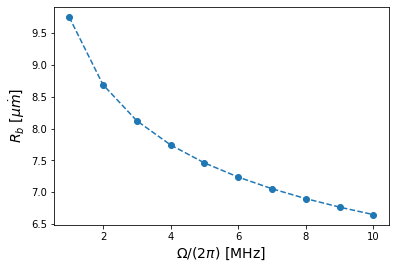

In [2]:
Rabi = np.linspace(1, 10, 10)
R_blockade = [
    MockDevice.rydberg_blockade_radius(2.0 * np.pi * rabi) for rabi in Rabi
]

plt.figure()
plt.plot(Rabi, R_blockade, "--o")
plt.xlabel(r"$\Omega/(2\pi)$ [MHz]", fontsize=14)
plt.ylabel(r"$R_b$ [$\mu\.m$]", fontsize=14)
plt.show()

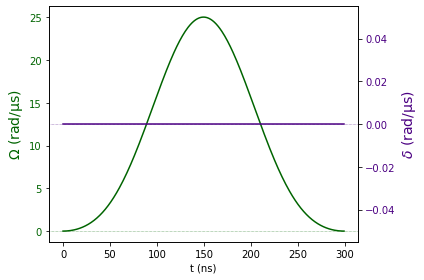

In [3]:
duration = 300
pi_Y = Pulse.ConstantDetuning(
    BlackmanWaveform(duration, np.pi), 0.0, -np.pi / 2
)
pi_Y.draw()

pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0.0, 0)
twopi_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(duration, 2 * np.pi), 0.0, 0
)

In [4]:
def build_state_from_id(s_id, basis_name):
    #if len(s_id) not in {2, 3, 4}:
    #    raise ValueError("Not a valid state ID string")

    ids = {"digital": "gh", "ground-rydberg": "rg", "all": "rgh"}
    if basis_name not in ids:
        raise ValueError("Not a valid basis")

    pool = {"".join(x) for x in product(ids[basis_name], repeat=len(s_id))}
    if s_id not in pool:
        raise ValueError("Not a valid state id for the given basis.")

    ket = {
        op: qutip.basis(len(ids[basis_name]), i)
        for i, op in enumerate(ids[basis_name])
    }
    if len(s_id) == 3:
        # Recall that s_id = 'C1'+'C2'+'T' while in the register reg_id = 'C1'+'T'+'C2'.
        reg_id = s_id[0] + s_id[2] + s_id[1]
        return qutip.tensor([ket[x] for x in reg_id])
    else:
        return qutip.tensor([ket[x] for x in s_id])

In [5]:
def preparation_sequence(state_id, reg):
    global seq

    if not set(state_id) <= {"g", "h"} or len(state_id) != len(reg.qubits):
        raise ValueError("Not a valid state ID")

    seq = Sequence(reg, MockDevice)
    if set(state_id) == {"g"}:
        basis = "ground-rydberg"
    else:
        basis = "all"
        for k in range(len(reg.qubits)):
            if state_id[k] == "h":
                if "raman" not in seq.declared_channels:
                    seq.declare_channel(
                        "raman", "raman_local", list(q_dict.keys())[k]#seq_dict[str(k)]
                    )
                else:
                    seq.target(list(q_dict.keys())[k], "raman")
                seq.add(pi_Y, "raman")

    prep_state = build_state_from_id(
        state_id, basis
    )  # Raises error if not a valid `state_id` for the register

    return prep_state

In [6]:
import functools
from itertools import chain
theta = np.pi/2
rx = np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
], dtype=int)
ry = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
], dtype=int)
rz = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
], dtype=int)

# get all possible rotations on a cube
rotprod = chain(*[product([rx, ry, rz], repeat=i) for i in range(1,7)])
rotrots = [functools.reduce(np.dot, rs) for rs in rotprod]
rots = []
for rs in rotrots:
    unique = True
    for r in rots:
        if np.array_equal(rs, r):
            unique = False
    if unique:
        rots.append(rs)
print('Unique rotations:', len(rots))

24

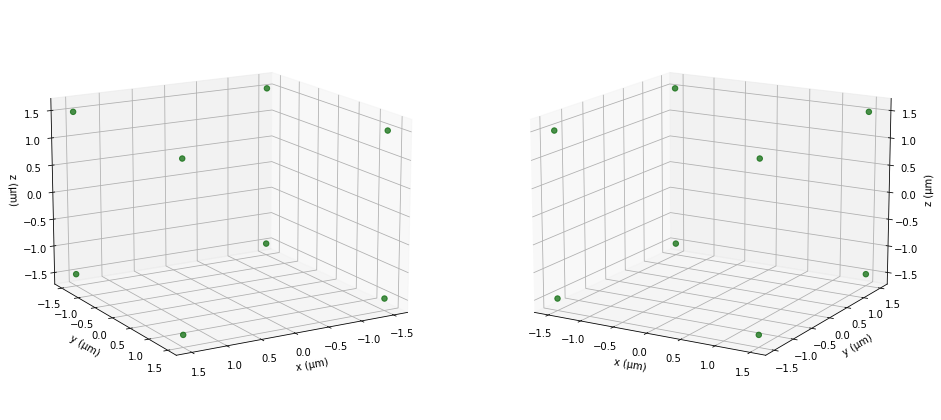

3
[({'000'}, {'001'}), ({'000'}, {'011'}), ({'000'}, {'111'})]


In [7]:
ntot = 8
nctrl = 1
ntarget = 1
a = 3
# Atom Register and Device
q_dict = {
    "000": np.array([-a/2, -a/2, -a/2]),
    "001": np.array([-a/2, -a/2,  a/2]),
    "010": np.array([-a/2,  a/2, -a/2]),
    "011": np.array([-a/2,  a/2,  a/2]),
    "100": np.array([ a/2, -a/2, -a/2]),
    "101": np.array([ a/2, -a/2,  a/2]),
    "110": np.array([ a/2,  a/2, -a/2]),
    "111": np.array([ a/2,  a/2,  a/2])
}
q_dict_rev = dict([(tuple(y), x) for x,y in q_dict.items()])

reg = Register3D(q_dict)
reg.draw()
nbits = len(reg.qubits)
qubits = list(q_dict.keys())

interacting = list(combinations(qubits, nctrl+ntarget))
controls_unfiltered = [set(qs[:nctrl]) for qs in interacting]
targets_unfiltered = [set(qs[nctrl:]) for qs in interacting]
controltarget = []
for cs,ts in zip(controls_unfiltered, targets_unfiltered):
    adding = True
    if cs.intersection(ts) or len(cs) != nctrl or len(ts) != ntarget:
        continue
    for rot in rots:
        c_rot = set(map(lambda c : q_dict_rev[tuple(np.dot(rot, q_dict[c]))], cs))
        t_rot = set(map(lambda t : q_dict_rev[tuple(np.dot(rot, q_dict[t]))], ts))

        for added_c,added_t in controltarget:
            if c_rot == added_c and t_rot == added_t:
                adding = False
    if adding:
        controltarget.append((cs, ts))
print(len(controltarget))
print(controltarget)

In [8]:
def CCZ_sequence(initial_id, ctls, tgts):
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg)
    prep_time = max(
        (seq._last(ch).tf for ch in seq.declared_channels), default=0
    )

    # Declare Rydberg channel
    seq.declare_channel("ryd", "rydberg_local", ctls[0])

    # Write CCZ sequence:
    seq.add(
        pi_pulse, "ryd", protocol="wait-for-all"
    )  # Wait for state preparation to finish.
    for c in ctls[1:]:
        seq.target(c, "ryd")
        seq.add(pi_pulse, "ryd")
    for t in tgts:
        seq.target(t, "ryd")
        seq.add(twopi_pulse, "ryd")
    for c in reversed(ctls):
        seq.target(c, "ryd")
        seq.add(pi_pulse, "ryd")

    return prep_state, prep_time

In [9]:
prod = list(product("gh", repeat=nctrl+ntarget))
keys = list(q_dict.keys())
accuracies = []
for cs, ts in controltarget:
    CCZ = {}
    final_state = []
    states = ['g' * nbits for _ in range(len(prod))]
    counter = 0
    for c in list(cs) + list(ts):
        idx = keys.index(c)
        states = [s[:idx] + prod[i][counter] + s[idx+1:] for i,s in enumerate(states)]
        print(idx, end='')
        counter += 1
    print(' ', states)
    for state_id in states:
        # Get CCZ sequence
        prep_state, prep_time = CCZ_sequence(state_id, list(cs), list(ts))
        #seq.draw(draw_phase_area=True)
        # Construct Simulation instance
        simul = Simulation(seq)

        res = simul.run()

        #data = [st.overlap(prep_state) for st in res.states]
        final_st = res.states[-1]
        CCZ[state_id] = final_st.overlap(prep_state)
    print(CCZ)
    acc = np.average([np.abs(x.real) for x in CCZ.values()])
    accuracies.append(acc)
print(accuracies)

01  ['gggggggg', 'ghgggggg', 'hggggggg', 'hhgggggg']
{'gggggggg': (-0.9999706155693552+0.007666027949975625j), 'ghgggggg': (-0.9999999978729652+1.836970194813738e-16j), 'hggggggg': (-0.9999999991056826+1.8369701970782017e-16j), 'hhgggggg': (0.9999999993150871-3.673940394925729e-16j)}
03  ['gggggggg', 'ggghgggg', 'hggggggg', 'hgghgggg']


In [ ]:
res = {
    (2,1,1) : [0.9999805025068218, 0.9999963728679664, 0.9999587299920651],
    (3,1,1) : [0.9999926529657724, 0.9995303113080015, 0.9946979203225159],
    (4,1,1) : [0.9997681847441849, 0.9855603650236259, 0.8684395006520712],
    (3,2,1) : [0.9997522624032423, 0.9994954069517215, 0.9968479401659007, 0.997194811741478, 0.998943025340594, 0.9998420466562205, 0.9973949176374772],
    (4,2,1) : [0.9844859792102197, 0.9923727325651863, 0.8588598756190757, 0.8469694658435067, 0.9675210665931169, 0.9950024161249967, 0.9448003426037904],
    (3,1,2) : [0.9999779606151085, 0.9994641573447232, 0.9994642143353142, 0.9994642236839961, 0.9944946339262098, 0.9985917163113659, 0.9926645642690741],
    (3,2,2) : [0.999161437697077, 0.999264615968588, 0.9991614535857991, 0.995761543979261, 0.9936867878345823, 0.999161448962393, 0.995778443353284, 0.9922675209925058, 0.9888679909012406, 0.995414805211316, 0.995414805211316, 0.9908114341900642, 0.9973007105604386, 0.9988146680079925, 0.993552908443244, 0.9970489055989347, 0.9988146833549795, 0.9969655418895367, 0.9956604751197566, 0.9969655647353419]
}

: 